In [2]:
import os
import datetime
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
import seaborn as sns
%matplotlib inline
from __future__ import print_function
import numpy as np
import statsmodels.api as sm
from scipy import stats

test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation,TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

In [4]:
traindata=train[['Id', 'Text','Score' ]]
traindata=traindata[:100000]

In [4]:

stemmer = SnowballStemmer("english")
tokenizer = RegexpTokenizer("[a-z']+")

def tokenize(text):
    tokens = tokenizer.tokenize(text)
    return [stemmer.stem(t) for t in tokens] 

def get_tf(data, use_idf, max_df=1.0, min_df=1, ngram_range=(1,1)):
    if use_idf:
        m = TfidfVectorizer(max_df=max_df, min_df=min_df, stop_words='english', ngram_range=ngram_range, tokenizer=tokenize)
    else:
        m = CountVectorizer(max_df=max_df, min_df=min_df, stop_words='english', ngram_range=ngram_range, tokenizer=tokenize)
    
    d = m.fit_transform(data)
    return m, d

tf_m, tf_d = get_tf(traindata['Text'], use_idf=False, max_df=0.90, min_df=10)
tfidf_m, tfidf_d = get_tf(traindata['Text'], use_idf=True, max_df=0.90, min_df=10)

In [5]:

n_topics = 5

def get_lda(data, topics):
    m = LatentDirichletAllocation(n_topics=topics, n_jobs=-1, learning_method='online').fit(data)
    d = m.transform(data)
    return m, d

def get_kmeans(data, k, scale=True):
    if scale:
        s = MinMaxScaler()
        data = s.fit_transform(data)
    
    m = KMeans(n_clusters=k).fit(data)
    d = m.predict(data)
    return m, d        

lda_m, lda_d = get_lda(tf_d, n_topics)
kmean_m, kmean_d = get_kmeans(tfidf_d, n_topics, scale=False)


AttributeError: 'CountVectorizer' object has no attribute 'to_csv'

In [6]:
from sklearn.externals import joblib
joblib.dump(tf_m, 'tf_m.pkl')
joblib.dump(tf_d, 'tf_d.pkl')
joblib.dump(tfidf_m, 'tfidf_m.pkl')
joblib.dump(tfidf_d, 'tfidf_d.pkl')

joblib.dump(lda_m, 'lda_m.pkl')
joblib.dump(lda_d, 'lda_d.pkl')
joblib.dump(kmean_m, 'kmean_m.pkl')
joblib.dump(kmean_d, 'kmean_d.pkl')


['kmean_d.pkl']

In [7]:

def show_topics(model, feature_names, n_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-n_words - 1:-1]]))
    print()
    
def show_cluster_topics(cluster_labels, tf_matrix, feature_names, n_words):
    d = pd.DataFrame(tf_matrix.toarray())
    d['c'] = cluster_labels
    d = d.groupby('c').sum().T
    
    for col in d:
        top_n = d[col].nlargest(n_words).index.tolist()
        print("Cluster #%d:" % col)
        print(", ".join([feature_names[i]
                for i in top_n]))
    print()
    
print("Top 15 stemmed words per topic in LDA model\n")
show_topics(lda_m, tf_m.get_feature_names(), 10)

Top 15 stemmed words per topic in LDA model

Topic #0:
coffe, tea, flavor, tast, cup, like, drink, tri, good, veri
Topic #1:
amazon, product, order, price, store, buy, great, love, veri, box
Topic #2:
tast, like, flavor, good, great, chocol, tri, just, eat, use
Topic #3:
br, use, just, like, water, review, product, don't, time, bag
Topic #4:
food, dog, treat, cat, love, eat, like, tri, year, chew



In [8]:

print("Top 15 stemmed words per cluster in Kmeans model\n")
show_cluster_topics(kmean_d, tfidf_d, tfidf_m.get_feature_names(), 10)

Top 15 stemmed words per cluster in Kmeans model

Cluster #0:
coffe, cup, flavor, k, tast, like, strong, br, good, roast
Cluster #1:
tast, great, product, like, good, love, flavor, veri, use, just
Cluster #2:
dog, food, cat, treat, love, eat, br, like, product, chew
Cluster #3:
tea, drink, green, flavor, tast, br, like, bag, love, good
Cluster #4:
br, like, tast, product, flavor, good, just, use, tri, veri



In [5]:
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)     
    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    if hasattr(offsetbox, 'AnnotationBbox'):
        ## only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                ## don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)



from sklearn.externals import joblib
tfidf_d = joblib.load('tfidf_d.pkl')
lda_d = joblib.load('lda_d.pkl')
X_pca = TruncatedSVD(n_components=2).fit_transform(tfidf_d)
plot_embedding(X_pca,"Principal Components projection of the digits" )
               

In [6]:
from sklearn.externals import joblib
tfidf_d = joblib.load('tfidf_d.pkl')
lda_d = joblib.load('lda_d.pkl')
def get_svd(data, components):
    svd = TruncatedSVD(n_components=components).fit(data)
    o = pd.DataFrame(svd.transform(data), columns=range(0,components))
    return svd,o

svd_v, svd_m = get_svd(tfidf_d, 30)


In [6]:
svd_m

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.140373,0.036602,-0.050471,0.092171,0.013431,-0.013556,0.024813,-0.012906,-0.002458,-0.050426,...,-0.041047,0.023485,-0.000664,-0.016927,-0.038581,-0.014161,0.039358,-0.023132,-0.022815,-0.028860
1,0.118535,-0.018920,-0.072004,-0.028304,0.004062,0.079695,0.069286,-0.008529,-0.013836,0.010188,...,0.017445,-0.026432,-0.035448,0.015553,0.024374,0.025784,0.007621,0.005039,-0.029240,-0.002097
2,0.062673,-0.024266,-0.022700,-0.009024,-0.047087,-0.007253,-0.000752,0.047469,-0.106212,-0.020471,...,0.027303,-0.006467,-0.007726,-0.022864,0.015949,-0.010631,-0.043298,0.003538,-0.013371,0.007350
3,0.193255,-0.081024,0.203855,-0.006299,0.031090,-0.016199,0.000275,-0.006949,-0.025585,-0.030510,...,-0.076293,0.016111,0.014770,0.003309,-0.025721,-0.009893,0.004559,-0.002180,-0.059307,-0.012441
4,0.148397,0.027113,-0.049810,-0.026646,-0.071946,0.030391,0.002138,-0.061788,0.034732,0.070508,...,-0.043796,0.109176,-0.112489,0.041958,-0.077278,0.031247,-0.085913,0.126054,-0.043928,-0.047191
5,0.327825,-0.166861,0.320880,0.026776,-0.045998,-0.097484,-0.051560,0.085897,0.141641,-0.054610,...,-0.018407,-0.022658,-0.086134,-0.012016,-0.042410,-0.005082,-0.024964,0.022648,-0.034074,-0.015532
6,0.137860,0.099348,-0.053274,0.302964,0.076032,0.021864,0.010048,0.044774,-0.012196,-0.005608,...,-0.017270,-0.024611,0.008683,0.003171,0.011150,-0.006501,-0.010287,-0.010145,0.034341,0.015686
7,0.130317,-0.034498,-0.061432,-0.018288,-0.037373,0.012351,0.021987,-0.037101,0.032334,0.050079,...,0.044957,-0.038885,0.001957,-0.001908,-0.061594,0.013657,0.041924,-0.057988,-0.013853,-0.062480
8,0.123726,-0.019862,-0.064315,-0.015703,-0.012719,0.125302,0.020992,-0.082209,0.005012,-0.016877,...,0.008904,0.011142,0.004884,-0.118490,-0.050589,-0.024553,0.008966,0.012130,-0.019247,-0.036536
9,0.097029,-0.036316,0.031755,-0.003370,0.003848,0.003311,0.005846,-0.007658,-0.001290,-0.008670,...,0.021292,0.002530,-0.018693,-0.026783,-0.014181,-0.016430,0.026103,-0.000981,-0.002609,-0.022676


In [18]:
from sklearn.utils.extmath import randomized_svd

U, Sigma, VT = randomized_svd(tfidf_d, 
                              n_components=30,
                              n_iter=5,
                              random_state=None)

In [19]:

pd.DataFrame(VT)

,0,1,2,3,4,5,6,7,8,9,...,8605,8606,8607,8608,8609,8610,8611,8612,8613,8614
0,0.002086,0.000774,0.002505,0.000206,0.000123,0.000180,0.000210,0.000393,1.227089e-04,1.025506e-04,...,0.000172,0.000526,0.000466,0.000126,0.000143,0.000430,0.000239,0.000147,0.000310,0.003125
1,-0.000622,-0.000664,-0.001206,0.000319,-0.000252,-0.000194,0.000155,-0.000283,-6.642554e-05,-4.051959e-05,...,-0.000199,-0.001031,-0.000426,-0.000044,0.000092,-0.000430,-0.000102,0.000119,-0.000344,-0.005414
2,0.000495,-0.000158,-0.000384,0.000256,0.000028,0.000219,-0.000014,-0.000054,-4.485266e-05,-9.082368e-05,...,0.000051,-0.000662,-0.000513,-0.000082,0.000049,-0.000052,-0.000319,0.000006,-0.000029,-0.005900
3,-0.000170,-0.000279,0.000233,-0.000269,-0.000070,0.000009,-0.000119,-0.000163,5.285373e-05,2.882531e-05,...,-0.000028,-0.000504,-0.000263,-0.000041,-0.000088,-0.000121,-0.000083,-0.000013,-0.000088,-0.003630
4,-0.000527,-0.000145,-0.001869,0.000088,0.000198,-0.000114,-0.000158,0.000385,-1.007563e-04,-6.103622e-05,...,-0.000188,0.001670,0.000073,-0.000168,0.000035,-0.000317,-0.000287,0.000048,-0.000128,0.011914
5,-0.000192,0.000189,0.000631,-0.000013,-0.000111,0.000188,0.000057,-0.000301,1.165051e-04,-7.153734e-05,...,0.000022,-0.000289,0.000203,-0.000047,-0.000020,-0.000395,0.000073,0.000231,-0.000048,-0.002539
6,0.000405,-0.000450,-0.000152,0.000065,0.000256,0.000004,0.000093,0.000004,5.255120e-07,5.825882e-06,...,0.000178,0.000448,-0.000291,0.000081,0.000073,-0.000336,-0.000057,0.000079,0.000551,-0.016656
7,-0.000758,0.000304,0.000053,0.000004,0.000159,-0.000074,-0.000232,0.000004,-1.317474e-04,-1.984655e-04,...,-0.000447,-0.000115,-0.001165,-0.000157,-0.000167,0.000107,0.000364,0.000044,-0.000587,-0.001212
8,0.000769,-0.000331,0.001490,-0.000015,0.000135,0.000145,-0.000050,0.000196,-4.510489e-05,1.334221e-04,...,-0.000266,-0.000031,-0.000447,-0.000094,0.000069,0.001364,0.000054,0.000119,-0.000355,-0.000625
9,-0.001493,-0.000067,-0.000838,-0.000242,0.000028,-0.000159,-0.000540,-0.000057,-2.357401e-05,1.542721e-05,...,0.000056,0.000236,-0.000321,-0.000080,-0.000189,-0.000088,0.000038,-0.000420,0.000438,-0.000661


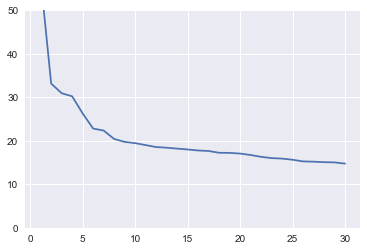

In [22]:
### plt.xlim([0,20])
plt.ylim([0,50])
plt.plot(range(1,len(Sigma)+1),Sigma)

In [ ]:

def get_tsne(data, components, perplexity):
    tsne = TSNE(n_components=components, perplexity=perplexity, n_iter=1000)
    o = pd.DataFrame(tsne.fit_transform(data), columns=range(0,components))
    return tsne,o

#svd_v, svd_m = get_svd(tfidf_d, 50)
tnse_v, tsne_m = get_tsne(svd_m, 2, 25)

lda_c = lda_d.argmax(axis=1)


def plot_scatter_2d(x, y, c, sample_size, title):
    df = pd.DataFrame({'x': x, 'y': y, 'c': c}).sample(sample_size)
    l = len(np.unique(c))
    
    ax = plt.subplot(111)
    colors = cm.rainbow(np.linspace(0, 1, l))
                                   
    for c in range(0,l):
        qq = df[df['c']==c]
        ax.scatter(qq['x'], qq['y'],c=colors[c], label=c)
    plt.legend(loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0), title='Topic/Cluster')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(title)
    plt.show()

%matplotlib inline
plot_scatter_2d(tsne_m[0], tsne_m[1], kmean_d, 1000, 'KMeans Clustering of Amazon Reviews using TFIDF (t-SNE Plot)')

%matplotlib inline
plot_scatter_2d(tsne_m[0], tsne_m[1], lda_c, 1000, 'LDA Topics of Amazon Reviews using TF (t-SNE Plot)')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_d, traindata['Score'], test_size=0.3)

In [7]:
type(traindata['Score'][2])
cat = [int(1),int(2),int(3),int(4.0),int(5.0)]
type(cat[1])

int

In [28]:

def calculate_cv(X, y):
    results = {
        'lr': [],
        'svm': [],
        'nb': [],
        'combined': []
    }
    lm = LogisticRegression()
    svm = LinearSVC()
    nb = MultinomialNB()
    vc = VotingClassifier([('lm', lm), ('svm', svm), ('nb', nb)])
    
    for c in cat:
        y_adj = np.array(round(y)==c)
        results['lr'].append((cross_val_score(lm, X, y_adj, cv=10, scoring='mean_squared_error').mean(), c))
        results['svm'].append((cross_val_score(svm, X, y_adj, cv=10, scoring='mean_squared_error').mean(), c))
        results['nb'].append((cross_val_score(nb, X, y_adj, cv=10, scoring='mean_squared_error').mean(), c))
        results['combined'].append((cross_val_score(vc, X, y_adj, cv=10, scoring='mean_squared_error').mean(), c))
    return results

cv_scores = calculate_cv(X_test, y_test)

print("Model accuracy predictions measured by RMSE\n")
for m,s in cv_scores.items():
    for ss in s:
        print("{M} model ({R} rating): {S}".format(M=m.upper(), R=ss[1], S=ss[0]))
    print()

/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the

/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the

/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the

/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the

/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the

/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the

/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the

/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the

/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the

/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the

/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the

/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the

/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the

Model accuracy predictions

LR model (1.0 rating): -0.07523324004073037
LR model (2.0 rating): -0.05316663806295979
LR model (3.0 rating): -0.07436648604072069
LR model (4.0 rating): -0.14263325874443616
LR model (5.0 rating): -0.2011655955850662

SVM model (1.0 rating): -0.07059976187404761
SVM model (2.0 rating): -0.05503320488887462
SVM model (3.0 rating): -0.07603310844812317
SVM model (4.0 rating): -0.14909980331849665
SVM model (5.0 rating): -0.21523204133318977

NB model (1.0 rating): -0.09103330809258978
NB model (2.0 rating): -0.0529999713740709
NB model (3.0 rating): -0.07459991939999105
NB model (4.0 rating): -0.14436666987407445
NB model (5.0 rating): -0.24436649938887028

COMBINED model (1.0 rating): -0.07543335115926124
COMBINED model (2.0 rating): -0.05309997138888571
COMBINED model (3.0 rating): -0.07436646381849599
COMBINED model (4.0 rating): -0.14209988095183862
COMBINED model (5.0 rating): -0.20283239574063655



/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/charleneyu1221/anaconda/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,


In [8]:
def calculate_cv(X, y):
    results = {
        'lr': [],
        'svm': [],
        'nb': [],
        'combined': []
    }
    lm = LogisticRegression()
    svm = LinearSVC()
    nb = MultinomialNB()
    vc = VotingClassifier([('lm', lm), ('svm', svm), ('nb', nb)])
    
    for c in cat:
        y_adj = np.array(y==c)
        results['lr'].append((cross_val_score(lm, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['svm'].append((cross_val_score(svm, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['nb'].append((cross_val_score(nb, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['combined'].append((cross_val_score(vc, X, y_adj, cv=10, scoring='accuracy').mean(), c))
    return results

cv_scores = calculate_cv(X_test, y_test)

print("Model accuracy predictions\n")
for m,s in cv_scores.items():
    for ss in s:
        print("{M} model ({R} rating): {S:.1%}".format(M=m.upper(), R=ss[1], S=ss[0]))
    print()

Model accuracy predictions

LR model (1 rating): 92.6%
LR model (2 rating): 94.5%
LR model (3 rating): 92.5%
LR model (4 rating): 86.1%
LR model (5 rating): 80.2%

SVM model (1 rating): 93.0%
SVM model (2 rating): 94.2%
SVM model (3 rating): 92.2%
SVM model (4 rating): 85.5%
SVM model (5 rating): 78.7%

NB model (1 rating): 91.0%
NB model (2 rating): 94.5%
NB model (3 rating): 92.5%
NB model (4 rating): 86.0%
NB model (5 rating): 75.3%

COMBINED model (1 rating): 92.6%
COMBINED model (2 rating): 94.5%
COMBINED model (3 rating): 92.5%
COMBINED model (4 rating): 86.1%
COMBINED model (5 rating): 80.0%



In [31]:
import math
math.sqrt(0.20283239574063655)

0.45036917716539676

In [9]:

def get_lr(x, y):
    models = []
    for c in cat:
        y_adj = np.array(y==c)
        lm = LogisticRegression()
        lm_f = lm.fit(x, y_adj)
        models.append(lm_f)
    return models

lr_m = get_lr(X_train, y_train)

In [12]:
print(lr_m)

[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver=

In [ ]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train) 

clf.decision_function(X_test)
clf.predict(X_test)

In [5]:
test.head()

,Id,Score
0,413937,NaN
1,16525,NaN
2,221883,NaN
3,82207,NaN
4,8354,NaN


In [ ]:
def compute_mse_standard(x_train, y_train, x_test, y_test):
    """Computes MSE of an SVR with RBF kernel and default hyperparameters.
    """
    model = sklearn.svm.SVR().fit(x_train, y_train)
    predictions = model.predict(x_test)
    return optunity.metrics.mse(y_test, predictions)

# wrap with outer cross-validation
compute_mse_standard = outer_cv(compute_mse_standard)

In [10]:
import surprise 
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

data = surprise.Dataset.load_builtin('ml-100k')
data.split(2)  

In [12]:
type(data)

surprise.dataset.DatasetAutoFolds

In [16]:
#type(traindata['raw_ratings'])
traindata=traindata[[ 'Text','Score' ]]

traindata=traindata.rename(columns = {'Score':'raw_ratings'})

In [17]:
algo = SVD()
cross_validate(algo, traindata, measures=['RMSE', 'MAE'], cv=5, verbose=True)

AttributeError: 'DataFrame' object has no attribute 'construct_trainset'